# Time Series E2E Exercise

### by Elihezer Lopez

### Exercise Objective

The goal of this mini-project is to practice each stage of the pipeline throughout the time series module. We will use the earth surface temperature data offered by Berkeley Earth through Kaggle.com. We will select one location, could be a city or a state or something relatively similar in size and analyze the patterns in temperature over time. We will then model those patterns to forecast temperature into the future. 

In [1]:
# imports
import pandas as pd
import numpy as np
import os

from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

from matplotlib.ticker import StrMethodFormatter
from matplotlib.dates import DateFormatter

import statsmodels.api as sm
from statsmodels.tsa.api import Holt

import warnings
warnings.filterwarnings("ignore")

# Acquire and Prep

In [2]:
df = pd.read_csv('GlobalLandTemperaturesByCity.csv')

In [3]:
df.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1743-11-01,6.068,1.737,Århus,Denmark,57.05N,10.33E
1,1743-12-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
2,1744-01-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
3,1744-02-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
4,1744-03-01,NaN,NaN,Århus,Denmark,57.05N,10.33E


In [4]:
df.City[df.City.str.startswith('S')].unique()
# Found San Antonio

array(['São Bernardo Do Campo', 'São Caetano Do Sul', 'São Carlos',
       'São Gonçalo', 'São João De Meriti', 'São José',
       'São José Do Rio Prêto', 'São José Dos Campos',
       'São José Dos Pinhais', 'São Leopoldo', 'São Luís', 'São Paulo',
       'São Vicente', 'Saarbrücken', 'Sabadell', 'Sabará', 'Sabha',
       'Sabratah', 'Sabzevar', 'Sacramento', 'Sadiqabad', 'Safaqis',
       'Saga', 'Sagamihara', 'Sagar', 'Saharanpur', 'Saharsa', 'Sahiwal',
       'Saint Étienne', 'Saint Denis', 'Saint Helens', 'Saint Louis',
       'Saint Paul', 'Saint Petersburg', 'Saitama', 'Sakai', 'Sakata',
       'Sakura', 'Salalah', 'Salamanca', 'Salatiga', 'Salavat', 'Salem',
       'Salerno', 'Salihorsk', 'Salinas', 'Salt Lake City', 'Salta',
       'Saltillo', 'Salto', 'Salvador', 'Salzburg', 'Salzgitter',
       'Samara', 'Samarinda', 'Samarkand', 'Sambalpur', 'Sambhal',
       'Samsun', 'Samut Prakan', 'San Antonio', 'San Bernardino',
       'San Bernardo', 'San Carlos De Bariloche', 'San C

In [5]:
df = df[df['City'] == 'San Antonio']

In [6]:
df.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
6618616,1820-01-01,7.169,3.676,San Antonio,United States,29.74N,97.85W
6618617,1820-02-01,11.448,2.964,San Antonio,United States,29.74N,97.85W
6618618,1820-03-01,15.003,2.413,San Antonio,United States,29.74N,97.85W
6618619,1820-04-01,21.022,2.136,San Antonio,United States,29.74N,97.85W
6618620,1820-05-01,23.938,1.923,San Antonio,United States,29.74N,97.85W


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2325 entries, 6618616 to 6620940
Data columns (total 7 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   dt                             2325 non-null   object 
 1   AverageTemperature             2316 non-null   float64
 2   AverageTemperatureUncertainty  2316 non-null   float64
 3   City                           2325 non-null   object 
 4   Country                        2325 non-null   object 
 5   Latitude                       2325 non-null   object 
 6   Longitude                      2325 non-null   object 
dtypes: float64(2), object(5)
memory usage: 145.3+ KB


In [8]:
df.shape

(2325, 7)

In [9]:
df.isna().sum()

dt                               0
AverageTemperature               9
AverageTemperatureUncertainty    9
City                             0
Country                          0
Latitude                         0
Longitude                        0
dtype: int64

In [10]:
df[df.AverageTemperature.isna() == True]
# From 11-1821 to 12-1822 we're missing a total of nine values, so we will ignore this data. 

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
6618638,1821-11-01,NaN,NaN,San Antonio,United States,29.74N,97.85W
6618639,1821-12-01,NaN,NaN,San Antonio,United States,29.74N,97.85W
6618640,1822-01-01,NaN,NaN,San Antonio,United States,29.74N,97.85W
6618641,1822-02-01,NaN,NaN,San Antonio,United States,29.74N,97.85W
6618642,1822-03-01,NaN,NaN,San Antonio,United States,29.74N,97.85W
6618648,1822-09-01,NaN,NaN,San Antonio,United States,29.74N,97.85W
6618649,1822-10-01,NaN,NaN,San Antonio,United States,29.74N,97.85W
6618650,1822-11-01,NaN,NaN,San Antonio,United States,29.74N,97.85W
6618651,1822-12-01,NaN,NaN,San Antonio,United States,29.74N,97.85W


In [11]:
df.dropna().shape

(2316, 7)

In [12]:
# dropped 9 rows with missing values. 
df = df.dropna()

In [13]:
df.dt.min(), df.dt.max() 

('1820-01-01', '2013-09-01')

In [14]:
df.dt.dtypes

dtype('O')

In [15]:
df.dt = pd.to_datetime(df.dt)
df.dt.dtypes

dtype('<M8[ns]')

In [16]:
df = df.set_index('dt')
df.head()

,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
dt,,,,,,
1820-01-01,7.169,3.676,San Antonio,United States,29.74N,97.85W
1820-02-01,11.448,2.964,San Antonio,United States,29.74N,97.85W
1820-03-01,15.003,2.413,San Antonio,United States,29.74N,97.85W
1820-04-01,21.022,2.136,San Antonio,United States,29.74N,97.85W
1820-05-01,23.938,1.923,San Antonio,United States,29.74N,97.85W


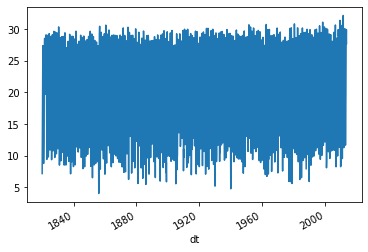

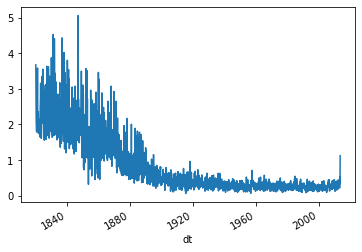

In [17]:
df.AverageTemperature.plot()
plt.show()
df.AverageTemperatureUncertainty.plot()
plt.show()

#Takeaways
- Temperature appears to have been taken in celsius since it appears to range from 0 to 30 only. San Antonio tends to be warmer than that in Farenheit. 
- Will need to convert temperature
- AvgTempUncertainty has signigicantly reduced over the years. 

In [18]:
# Formula = (0°C × 9/5) + 32 = 32°F
df["avg_temp_F"] = (df.AverageTemperature * 9/5) + 32

In [19]:
df.head()

,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,avg_temp_F
dt,,,,,,,
1820-01-01,7.169,3.676,San Antonio,United States,29.74N,97.85W,44.9042
1820-02-01,11.448,2.964,San Antonio,United States,29.74N,97.85W,52.6064
1820-03-01,15.003,2.413,San Antonio,United States,29.74N,97.85W,59.0054
1820-04-01,21.022,2.136,San Antonio,United States,29.74N,97.85W,69.8396
1820-05-01,23.938,1.923,San Antonio,United States,29.74N,97.85W,75.0884


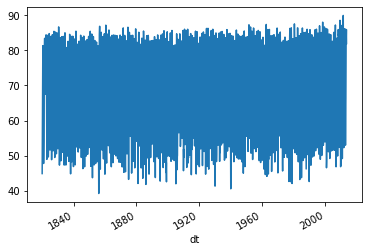

In [20]:
df.avg_temp_F.plot()
plt.show()

In [23]:
#new range of temps
df.avg_temp_F.min(), df.avg_temp_F.max()

(39.2414, 89.8988)

In [32]:
df = df.drop(['City', 'Country', 'Latitude', 'Longitude', 'AverageTemperature'], axis=1)

In [38]:
df.rename(columns={'AverageTemperatureUncertainty': 'uncertainty'}, inplace = True)

In [41]:
df.to_csv('avg_temp_san_antonio.csv')

# Split (Based on proportion)

In [33]:
def split():
    train_size = int(len(df) * .5)
    print(f"train = {train_size}")
    validate_size = int(len(df) * .3)
    print(f"validate = {validate_size}")
    test_size = int(len(df) - train_size - validate_size)
    print(f"test = {test_size}")
    validate_end_index = train_size + validate_size
    print(f"validate_end_index = {validate_end_index}")
    train = df[:train_size]
    validate = df[train_size : validate_end_index]
    test = df[validate_end_index : ]
    return train, validate, test

In [43]:
train, validate, test = split()

train = 1158
validate = 694
test = 464
validate_end_index = 1852


# Verify

In [44]:
train.shape, validate.shape, test.shape

((1158, 2), (694, 2), (464, 2))

In [45]:
print(len(train) + len(validate) + len(test) == len(df))

True


In [46]:
print(df.head(1) == train.head(1))

            uncertainty  avg_temp_F
dt                                 
1820-01-01         True        True


# Plot

In [47]:
def plot_samples(target_var):
    '''
    this function will plot the train, validate and test values for a single variable across all dates. 
    '''
    plt.figure(figsize=(12,4))
    plt.plot(train[target_var])
    plt.plot(validate[target_var])
    plt.plot(test[target_var])
    plt.title(target_var)

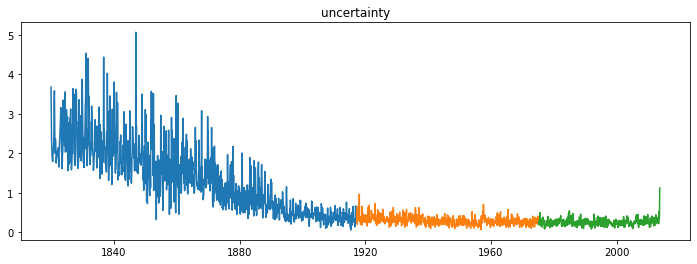

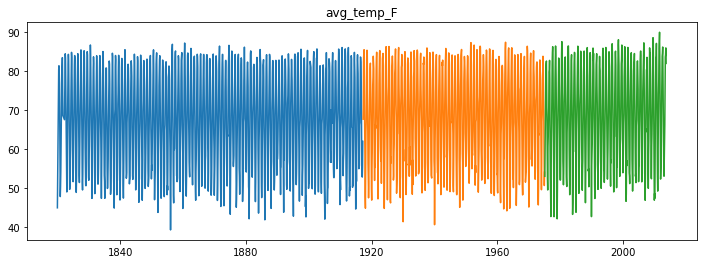

In [49]:
for col in train.columns:
    plot_samples(col)

In [50]:
def evaluate(target_var):
    '''
    the evaluate function will take in the actual values in validate and the predicted values 
    and compute the mean_squared_error and then take the square root and round to 0 decimals.
    It will return the rmse, an integer.
    '''
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse

In [51]:
def plot_and_eval(target_var):
    '''
    a function to evaluate forecasts by computing the rmse and plot train and validate along with predictions
    '''
    plot_samples(target_var)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '--RMSE: {:.0f}'.format(rmse))
    plt.show()

In [52]:
eval_df = pd.DataFrame(columns = ['model_type', 'target_var', 'rmse'])
eval_df

,model_type,target_var,rmse


In [53]:
# Define function to store rmse for comparison purposes

def append_eval_df(model_type, target_var):
    '''
    this function is going to take in the model_type as a string, the target variable as a string,
    and run the evaluate() function to compute the rmse,
    and append the data frame a row with the model_type, target_var, and rmse.
    It will return the new dataframe. 
    '''
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var], 'rmse':  [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index=True)

# Last Observed Value

In [58]:
u = train['uncertainty'][-1:][0]
at = round(train['avg_temp_F'][-1], 2)
yhat_df = pd.DataFrame({'uncertainty': [u], 'avg_temp_F': [at]}, index = validate.index)
yhat_df.head(2)

,uncertainty,avg_temp_F
dt,,
1917-04-01,0.278,61.94
1917-05-01,0.278,61.94


uncertainty --RMSE: 0


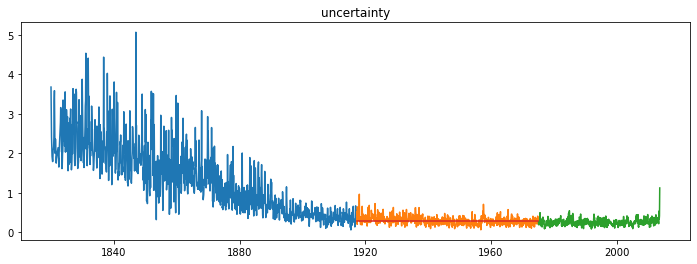

avg_temp_F --RMSE: 14


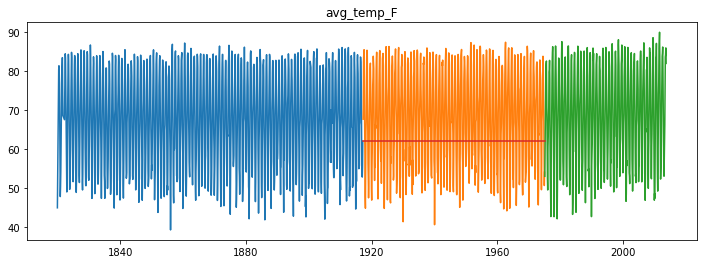

In [59]:
for col in train.columns:
    plot_and_eval(col)

In [60]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'last_observed_value', target_var = col)

In [61]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,uncertainty,0.0
1,last_observed_value,avg_temp_F,14.0
